# 準備

## ライブラリ

In [ ]:
!pip install --upgrade xlrd==1.2.0
!pip install openpyxl
!pip install japanize-matplotlib

In [130]:
import urllib.parse
import urllib.request
import json
import os
import pandas as pd
import numpy as np
import xlrd
import openpyxl
import matplotlib.pyplot as plt
import japanize_matplotlib

## 都道府県一覧

[RESAS-API](https://opendata.resas-portal.go.jp/docs/api/v1/prefectures.html)を利用する

利用者登録した後、APIキーを設定

In [3]:
RESAS_API_KEY = '02JYzLqUOfTNVfiTWjLlR2g0YwEQPQ7caYxcnZaZ'

In [4]:
def preflist():
  url = 'https://opendata.resas-portal.go.jp/api/v1/prefectures'
  req = urllib.request.Request(url, headers={'X-API-KEY': RESAS_API_KEY})
  with urllib.request.urlopen(req) as response:
    res = json.loads(response.read().decode())
  
  return  pd.DataFrame(res['result'])

In [5]:
preflist().head()

,prefCode,prefName
0,1,北海道
1,2,青森県
2,3,岩手県
3,4,宮城県
4,5,秋田県


## 市区町村一覧

同じく[RESAS-API](https://opendata.resas-portal.go.jp/docs/api/v1/cities.html)を利用する

In [6]:
def citylist(prefCode=None):
    url = 'https://opendata.resas-portal.go.jp/api/v1/cities'
    req = urllib.request.Request(url, headers={'X-API-KEY': RESAS_API_KEY})
    with urllib.request.urlopen(req) as response:
        res = json.loads(response.read().decode())
    
    res = list(filter(lambda x: x['bigCityFlag'] != '1', res['result']))

    if prefCode:
      res = list(filter(lambda x: x['prefCode'] == prefCode, res))
    
    return pd.DataFrame(res)

In [7]:
# 全国の市区町村
citylist().head()

,prefCode,cityCode,cityName,bigCityFlag
0,1,01100,札幌市,2
1,1,01202,函館市,0
2,1,01203,小樽市,0
3,1,01204,旭川市,0
4,1,01205,室蘭市,0


In [8]:
# 兵庫県の市区町村
citylist(28).head()

,prefCode,cityCode,cityName,bigCityFlag
0,28,28100,神戸市,2
1,28,28201,姫路市,0
2,28,28202,尼崎市,0
3,28,28203,明石市,0
4,28,28204,西宮市,0


## estat-APIのデータ取得

[政府統計の総合窓口](https://www.e-stat.go.jp/)のAPIからデータを取得する関数

利用者登録した後、APP_IDを設定

In [9]:
ESTAT_APP_ID = '724e5b90772a3e9289f41a253e4e7e32438f4fff'

In [50]:
import urllib.parse
import urllib.request
import json

def get_estat_response(params):
  # appId
  params['appId'] = ESTAT_APP_ID
  
  # url生成
  url = 'http://api.e-stat.go.jp/rest/2.1/app/json/getStatsData?'
  url += urllib.parse.urlencode(params)

  # API取得
  with urllib.request.urlopen(url) as response:
    res = json.loads(response.read().decode('utf-8'))
  
  # DataFrameに変換
  VALUE = res['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE']
  df = pd.DataFrame(VALUE)
  
  return df

例えば総人口データの取得は次のとおり

In [45]:
params = {
    'statsDataId': '0000010101',
    'cdCat01': 'A1101',
    }
get_estat_response(params).head()

,@tab,@cat01,@area,@time,@unit,$
0,00001,A1101,00000,1975100000,人,111939643
1,00001,A1101,00000,1976100000,人,113094000
2,00001,A1101,00000,1977100000,人,114165000
3,00001,A1101,00000,1978100000,人,115190000
4,00001,A1101,00000,1979100000,人,116155000


# 1 計画策定の目的

# 2 播磨臨海地域の特徴

## 2-1 全国屈指のものづくり拠点

### 製造品出荷額（全国市区町村）

市区町村の製造品出荷額

[工業統計調査](https://www.e-stat.go.jp/dbview?sid=0003448126)の2020年確報データを利用する

In [67]:
def manufacture():
  params = {
      'statsDataId' : '0003448126',
      'cdCat01' : '32000120',
      'cdCat02' : '00',
      }
  
  # 工業統計の取得
  df = get_estat_response(params)
  
  # 市区町村リスト
  df_city = citylist()

  # merge
  df = pd.merge(df_city, df, left_on='cityCode', right_on='@cat03', how='left')

  # 欠損値を処理
  df = df.replace('X', 0).dropna()
  
  # 降順にソート
  df = df.astype({'$': 'int'}).sort_values('$', ascending=False)

  # 列の整理
  columns = {'prefCode':'prefCode','cityCode':'cityCode','cityName':'cityName','$':'製造品出荷額（万円）'}
  df = df[list(columns.keys())].rename(columns = columns)

  return df


In [68]:
df_manufacture = manufacture()
df_manufacture

,prefCode,cityCode,cityName,製造品出荷額（万円）
1001,23,23211,豊田市,1517165565
696,14,14130,川崎市,408279669
595,12,12219,市原市,406664255
695,14,14100,横浜市,392691150
1310,33,33202,倉敷市,387861070
...,...,...,...,...
884,20,20414,泰阜村,0
196,2,02303,今別町,0
197,2,02304,蓬田村,0
882,20,20412,売木村,0


csvに保存

In [69]:
df_manufacture.to_csv('/content/全国市区町村の製造品出荷額_2020.csv')

### 製造品出荷額（播磨臨海地域）

In [80]:
def harima():

  df = manufacture()

  # 播磨臨海地域を抽出
  harima = ['姫路市','加古川市','高砂市','明石市','播磨町','稲美町']
  df = df[df['cityName'].isin(harima)]

  # 合計値
  df = df.append(df.sum(numeric_only=True), ignore_index=True)

  return df

In [79]:
df_harima = harima()
df_harima

,prefCode,cityCode,cityName,製造品出荷額（万円）
0,28.0,28201,姫路市,233391158.0
1,28.0,28203,明石市,138532844.0
2,28.0,28210,加古川市,102080157.0
3,28.0,28216,高砂市,83527204.0
4,28.0,28382,播磨町,25157773.0
5,28.0,28381,稲美町,18781297.0
6,168.0,NaN,NaN,601470433.0


## 2-2 姫路港・東播磨港の取扱貨物

[港湾統計（2020年）](https://www.mlit.go.jp/k-toukei/R2kowan-datebase.html)を利用する

In [82]:
# ExcelデータのURLをセット
urls: dict = {
    'time' : '2020年',
    '輸出' : 'https://www.mlit.go.jp/k-toukei/content/001448037.xlsx',
    '輸入' : 'https://www.mlit.go.jp/k-toukei/content/001448038.xlsx',
    '移出' : 'https://www.mlit.go.jp/k-toukei/content/001448039.xlsx',
    '移入' : 'https://www.mlit.go.jp/k-toukei/content/001448040.xlsx',
}

In [85]:
print(urls['輸出'])

https://www.mlit.go.jp/k-toukei/content/001448037.xlsx


輸出・輸入・移出・移入とも同じ構成のExcelになっているので、EXCELのインポートからDataFameの整形までは共通関数でOK

In [83]:
import pandas as pd

def get_excel(url):
  # ブックの指定
  input_file_name = url
  input_book = pd.ExcelFile(input_file_name)
  
  # 統計結果は2番目のシート、上から2行は無視
  input_sheet_name = input_book.sheet_names
  df = input_book.parse(input_sheet_name[1],skiprows = 2)

  return df.astype({'トン数': 'int'})

港別に集計する関数も共通

In [109]:
import pandas as pd
import numpy as np

def port_kind(url, params):

  # EXCELをインポート
  df = get_excel(url)

  # 集計
  df = pd.pivot_table(df, index=['都道府県', '港名'], columns='品種名', values='トン数', margins=True, aggfunc=np.sum).reset_index()

  # 都道府県指定がある場合
  if 'prefecture' in params:
    df = df[df['都道府県'].isin(params['prefecture'])]

  # 港湾指定がある場合
  if 'port' in params:
    df = df[df['港名'].isin(params['port'])]

  # 品種指定がある場合
  if 'kind' in params:
    df = df[['都道府県','港名',] + params['kind']]

  # 欠損列を削除
  df = df.dropna(how='all', axis=1)

  return df

### 搬入（品目別）

In [124]:
def carryin(params):
  # 輸入
  df_import = port_kind(urls['輸入'], params)
  
  # 移入
  df_immigration = port_kind(urls['移入'], params)

  # 搬入（輸入＋移入）
  df = pd.concat([df_import, df_immigration]).groupby(['港名'], as_index=False).sum()

  # 転置
  df = df.transpose()
  columns = {(i): params['port'][i] for i in range(0, len(params['port']))}
  df = df.rename(columns = columns)
  df = df[1:]

  return df

姫路港

,姫路
品種名,
ＬＮＧ（液化天然ガス）,16944088
鉄鋼,1808797
石炭,1671900
化学薬品,916978
金属くず,518604


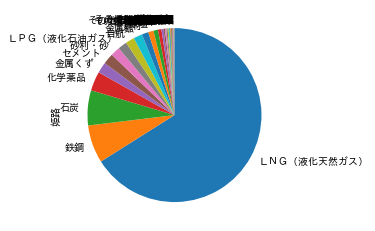

In [139]:
def df_carryin_himeji():
  df = carryin({'port':['姫路']})
  df = df.astype({'姫路': 'int'}).sort_values('姫路', ascending=False)
  df = df.drop('All', axis=0)
  return df

df_carryin_himeji()['姫路'].plot.pie(startangle=90, counterclock=False)
df_carryin_himeji().head()

東播磨港

,東播磨
品種名,
鉄鉱石,9415566
石炭,6691265
石灰石,1442736
砂利・砂,1389201
非金属鉱物,896228


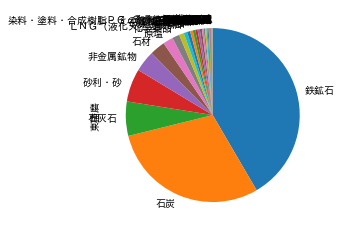

In [140]:
def df_carryin_higashi():
  df = carryin({'port':['東播磨']})
  df = df.astype({'東播磨': 'int'}).sort_values('東播磨', ascending=False)
  df = df.drop('All', axis=0)
  return df

df_carryin_higashi()['東播磨'].plot.pie(startangle=90, counterclock=False)
df_carryin_higashi().head()

### 搬出（品目別）

In [141]:
def carryout(params):
  # 輸出
  df_import = port_kind(urls['輸出'], params)
  
  # 移出
  df_immigration = port_kind(urls['移出'], params)

  # 搬出（輸出＋移出）
  df = pd.concat([df_import, df_immigration]).groupby(['港名'], as_index=False).sum()

  # 転置
  df = df.transpose()
  columns = {(i): params['port'][i] for i in range(0, len(params['port']))}
  df = df.rename(columns = columns)
  df = df[1:]

  return df

姫路港

,姫路
品種名,
鋼材,2672555
化学薬品,584786
自航,497315
砂利・砂,334006
石炭,317509


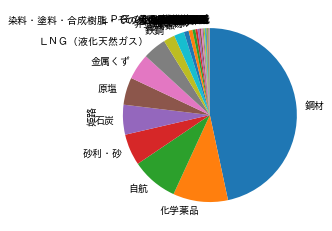

In [143]:
def df_carryout_himeji():
  df = carryout({'port':['姫路']})
  df = df.astype({'姫路': 'int'}).sort_values('姫路', ascending=False)
  df = df.drop('All', axis=0)
  return df

df_carryout_himeji()['姫路'].plot.pie(startangle=90, counterclock=False)
df_carryout_himeji().head()

東播磨港

,東播磨
品種名,
鋼材,3605496
砂利・砂,1684398
鉄鋼,1384356
非金属鉱物,768275
化学薬品,421069


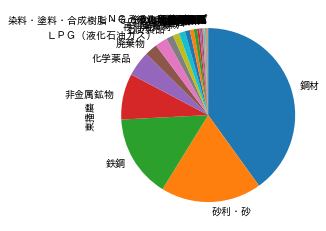

In [144]:
def df_carryout_higashi():
  df = carryout({'port':['東播磨']})
  df = df.astype({'東播磨': 'int'}).sort_values('東播磨', ascending=False)
  df = df.drop('All', axis=0)
  return df

df_carryout_higashi()['東播磨'].plot.pie(startangle=90, counterclock=False)
df_carryout_higashi().head()

## 2-3 全国港湾のLNG搬入量

In [161]:
def carryin_lng():
  params = {'kind':['ＬＮＧ（液化天然ガス）']}
  
  # 輸入
  df_import = port_kind(urls['輸入'], params)
  
  # 移入
  df_immigration = port_kind(urls['移入'], params)

  # 搬入（輸入＋移入）
  df = pd.concat([df_import, df_immigration]).groupby(['都道府県','港名'], as_index=False).sum()

  # 合計行を削除してソート
  df = df.astype({'ＬＮＧ（液化天然ガス）': 'int'}).sort_values('ＬＮＧ（液化天然ガス）', ascending=False)
  df = df[1:]

  return df

In [162]:
df_carryin_lng = carryin_lng()
df_carryin_lng.head()

品種名,都道府県,港名,ＬＮＧ（液化天然ガス）
30,千葉県,木更津,20746359
29,千葉県,千葉,18753798
10,兵庫県,姫路,16944088
87,愛知県,名古屋,14923308
110,神奈川県,川崎,14506083


# 3 基本的な事項

# 4 港湾地域の面的・効率的な脱炭素化


# 5 水素・燃料アンモニア等供給目標及び供給計画